In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm, BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool, global_add_pool
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score
import random
from statistics import mean

In [ ]:
# Read from csv
precut_sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
precut_bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [169]:
sig_df = precut_sig_df
bkg_df = precut_bkg_df

In [170]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_jet0 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_jet0 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_jet1 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet1|IsB")]]
bkg_jet1 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
train_df = pd.concat([sig_jet0, bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_jet1, bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [171]:
def train_make_cuts(train_df, test_df):
    train_cut_df = train_df.copy()
    test_cut_df = test_df.copy()
    
    train_cut_df_sig = train_cut_df[(train_cut_df['IsB'] == 1) & (train_cut_df['Jet0_MC_Match'] == 1) & (train_cut_df['Jet0_MC_Jet_EfB'] > 0.6)]
    train_cut_df_bkg = train_cut_df[(train_cut_df['IsB'] == 0) & (train_cut_df['Jet0_MC_Match'] == 1) & (train_cut_df['Jet0_MC_Jet_EfB'] < 0.6) & (train_cut_df['Jet0_MC_Jet_EfD'] < 0.6)]

    test_cut_df_sig = test_cut_df[(test_cut_df['IsB'] == 1) & (test_cut_df['Jet1_MC_Match'] == 1) & (test_cut_df['Jet1_MC_Jet_EfB'] > 0.6)]
    test_cut_df_bkg = test_cut_df[(test_cut_df['IsB'] == 0) & (test_cut_df['Jet1_MC_Match'] == 1) & (test_cut_df['Jet1_MC_Jet_EfB'] < 0.6) & (test_cut_df['Jet1_MC_Jet_EfD'] < 0.6)]
    
    train_cut_df = pd.concat([train_cut_df_sig, train_cut_df_bkg], ignore_index=True)
    test_cut_df = pd.concat([test_cut_df_sig, test_cut_df_bkg], ignore_index=True)
    return train_cut_df, test_cut_df

In [172]:
train_cut_df, test_cut_df = train_make_cuts(train_df, test_df)

In [173]:
# Cut out some data for quicker runs
#train_cut_df = pd.concat([train_cut_df.head(1000), train_cut_df.iloc[100000:101000]]) 
#test_cut_df = pd.concat([test_cut_df.head(1000), test_cut_df.iloc[100000:101000]])

In [174]:
train_df = train_cut_df
test_df = test_cut_df

In [175]:
# Print some results to verify
print("Training set:")
print(train_df[['IsB', 'Jet0_nDaughters', 'Jet0_MC_Match', 'Jet0_MC_Jet_EfB', 'Jet0_MC_Jet_EfD']].head())
print("\nTest set:")
print(test_df[['IsB', 'Jet1_nDaughters', 'Jet1_MC_Match', 'Jet1_MC_Jet_EfB', 'Jet1_MC_Jet_EfD']].head())

Training set:
   IsB  Jet0_nDaughters  Jet0_MC_Match  Jet0_MC_Jet_EfB  Jet0_MC_Jet_EfD
0    1               12              1         0.928622              0.0
1    1               13              1         0.875273              0.0
2    1               18              1         0.912982              0.0
3    1               26              1         0.785623              0.0
4    1               16              1         0.791983              0.0

Test set:
   IsB  Jet1_nDaughters  Jet1_MC_Match  Jet1_MC_Jet_EfB  Jet1_MC_Jet_EfD
0    1               15              1         0.946420              0.0
1    1               18              1         0.713616              0.0
2    1               13              1         0.901948              0.0
3    1               11              1         0.936195              0.0
4    1               10              1         0.863696              0.0


In [176]:
# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int, list)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

Data preprocessing

In [177]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT', 'Jet0_nmuons', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2']
test_jet_cols = ['Jet1_Eta', 'Jet1_PT', 'Jet1_nmuons', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2']

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

# Duplicate single features for each node and convert strings into float lists
train_df = duplicate(train_df, ['Jet0_Eta', 'Jet0_PT', 'Jet0_nmuons', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2'], 'Jet0_nDaughters')
test_df = duplicate(test_df, ['Jet1_Eta', 'Jet1_PT', 'Jet1_nmuons', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2'], 'Jet1_nDaughters')

train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

KeyboardInterrupt: 

In [ ]:
training_data = train_df[train_f_cols]

In [ ]:
training_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_Daughters_trackVZ,Jet0_Daughters_CaloNeutralEcal,Jet0_Daughters_CaloNeutralHcal2Ecal,Jet0_Daughters_CaloNeutralE49,Jet0_Daughters_CaloNeutralPrs,Jet0_Eta,Jet0_PT,Jet0_nmuons,Jet0_muon_ProbNNMu,Jet0_muon_IPchi2
0,"[351.5854797363281, 2111.6298828125, 4554.4291...","[88.37996673583984, 317.7222900390625, 727.219...","[22.0, 22.0, 211.0, 211.0, -2212.0, 22.0, 22.0...","[63.9700927734375, 178.0578155517578, 452.1048...","[-60.98234176635742, -263.1404113769531, -569....","[340.29595947265625, 2087.59033203125, 4493.82...","[2.057769298553467, 2.5814764499664307, 2.5208...","[-0.761491596698761, -0.9759039282798767, -0.8...","[0.0, 0.0, 1.0, 1.0, -1.0, 0.0, 0.0, 1.0, 0.0,...","[-100.0, -100.0, 0.0003153494617436081, 0.0056...",...,"[-1000.0, -1000.0, 4493.82861328125, 2070.1909...","[351.5854797363281, 2093.7978515625, -1000.0, ...","[0.0, 0.0, -1000.0, -1000.0, -1000.0, 0.093384...","[0.9631929397583008, 0.9523042440414429, -1000...","[0.0, 5.4854350090026855, -1000.0, -1000.0, -1...","[2.234644363718214, 2.234644363718214, 2.23464...","[30921.27913415401, 30921.27913415401, 30921.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
1,"[3886.169921875, 3567.995849609375, 558.150573...","[556.5562744140625, 653.4680786132812, 106.096...","[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 211...","[445.1024169921875, 583.787353515625, 23.78262...","[334.1238098144531, 293.6202087402344, 103.396...","[3846.110107421875, 3507.64501953125, 547.9741...","[2.6313908100128174, 2.382119655609131, 2.3442...","[0.643928050994873, 0.4660107493400574, 1.3447...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0,...","[-100.0, -100.0, -100.0, -100.0, -100.0, -100....",...,"[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[3368.008056640625, -1000.0, 558.1505737304688...","[0.0, -1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1000....","[0.8490092754364014, -1000.0, 0.95618653297424...","[43.334938049316406, -1000.0, 2.46844577789306...","[2.272611085616169, 2.272611085616169, 2.27261...","[26045.661101533577, 26045.661101533577, 26045...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
2,"[2013.1500244140625, 1101.718017578125, 1191.3...","[286.2803039550781, 121.03242492675781, 266.52...","[22.0, 22.0, 22.0, 22.0, -11.0, -211.0, 211.0,...","[-277.15869140625, -70.24822998046875, -195.23...","[71.69013214111328, 98.55979919433594, 181.437...","[1992.6907958984375, 1095.0496826171875, 1161....","[2.6385374069213867, 2.898683786392212, 2.1777...","[2.888479232788086, 2.19002628326416, 2.392811...","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 1.0, 0.0, 1.0,...","[-100.0, -100.0, -100.0, -100.0, -0.4075904786...",...,"[-1000.0, -1000.0, -1000.0, -1000.0, 10179.087...","[1923.607177734375, 1101.718017578125, 1076.85...","[0.0, 0.0, 0.0, 0.0, -1000.0, -1000.0, -1000.0...","[0.9398500323295593, 1.0210089683532715, 0.977...","[4.114076137542725, 46.07765579223633, 12.0679...","[2.5613067094464737, 2.5613067094464737, 2.561...","[32258.59988726735, 32258.59988726735, 32258.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
3,"[1836.97998046875, 1469.219970703125, 1413.670...","[495.4111022949219, 436.5097351074219, 295.793...","[22.0, 22.0, 22.0, -22.0, 211.0, 22.0, 22.0, 2...","[-492.4902038574219, -413.59130859375, -292.47...","[-53.71736526489258, 139.5814666748047, -44.15...","[1768.9158935546875, 1402.8779296875, 1382.378...","[1.9849375486373901, 1.883987307548523, 2.2463...","[-3.032949209213257, 2.8161089420318604, -2.99...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[-10

In [ ]:
len(train_df.Jet0_Daughters_ID[0])

26

In [ ]:
len(train_df.Jet0_muon_IPchi2[0])

26

Test - create gaussian distribution around 10 for background and 25 for signal (std = 5) to see if it picks up on it

In [16]:
# Create Gauss values for each daughter based on IsB column

def generate_gaussian(mean, std_dev):
    return random.gauss(mean, std_dev)

def generate_gaussian_list(row, mean1, mean2, std_dev):
    num_daughters = int(row['Jet0_nDaughters'] if 'Jet0_nDaughters' in row else row['Jet1_nDaughters'])
    mean = mean1 if row['IsB'] == 1 else mean2
    return [generate_gaussian(mean, std_dev) for _ in range(num_daughters)]

# Apply the function to create the new 'Gauss' column
train_df['Gauss'] = train_df.apply(lambda row: generate_gaussian_list(row, 10, 25, 5), axis=1)
test_df['Gauss'] = test_df.apply(lambda row: generate_gaussian_list(row, 10, 25, 5), axis=1)

# Print some results to verify
print("Training set:")
print(train_df[['IsB', 'Jet0_nDaughters', 'Gauss']].head())
print("\nTest set:")
print(test_df[['IsB', 'Jet1_nDaughters', 'Gauss']].head())

Training set:
   IsB  Jet0_nDaughters                                              Gauss
0    1               20  [6.37835937112145, 17.836168634314035, 16.9892...
1    1                9  [14.232326301791598, 10.162501847508773, 4.727...
2    1               13  [4.19950647313117, 6.057773588021476, 15.28180...
3    1               15  [22.115855959637898, 9.762280944921557, 12.420...
4    1                7  [20.632171524085926, 13.641282482504424, 12.21...

Test set:
   IsB  Jet1_nDaughters                                              Gauss
0    0               13  [26.12842944827144, 21.595885676724087, 30.917...
1    1               15  [14.861060491680261, 2.9346112076538766, 7.317...
2    1               10  [8.355866606117647, 18.079848366669882, 7.0592...
3    1               15  [16.122335819143274, 7.836201039177885, 14.438...
4    0               20  [26.901227292031162, 27.735766163506447, 19.55...


In [ ]:
# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, jet_features in enumerate(features_array):

        num_classes = 2 # binary classification
        x = torch.tensor(jet_features, dtype=torch.float)
        num_nodes = x.size(0)

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df, train_f_cols)
test_features = node_features(test_df, test_f_cols)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

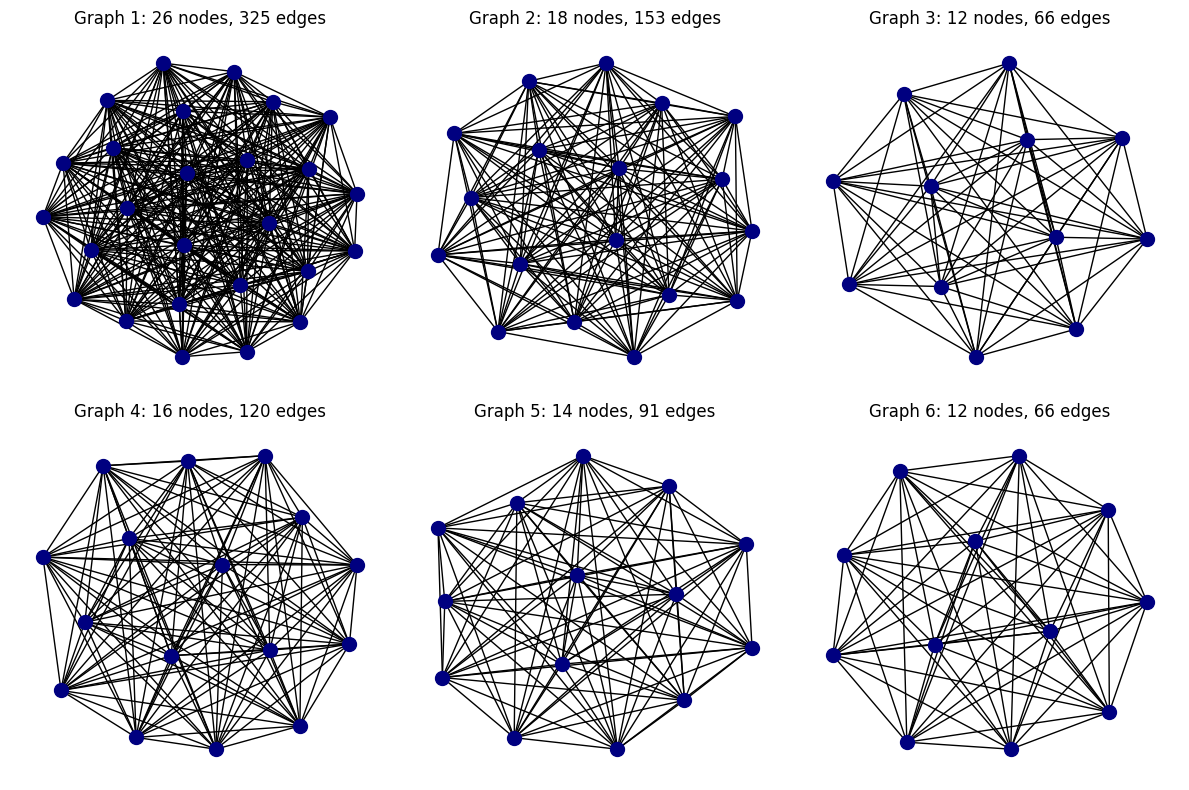

In [ ]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], node_color='navy', node_size=100)
    
    axes[i].set_title(f"Graph {i+1}: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

plt.tight_layout()
plt.show()

In [ ]:
for data in train_loader:
    print(f"x shape: {data.x[0]}") # [num_nodes, num_features]
    print(f"edge_index shape: {data.edge_index.shape[0]}") # [2, num_edges] fully connected
    print(f"y: {data.y}") # labels
    print(f"batch shape: {data.batch.shape[0]}") #num nodes in this batch
    print("###########################################")

x shape: tensor([ 1.0628e+03,  7.8678e+01, -2.2000e+01,  3.2749e+01,  7.1538e+01,
         1.0599e+03,  3.2951e+00,  1.1415e+00,  0.0000e+00, -1.0000e+02,
        -1.0000e+10, -1.0000e+02, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  2.8497e+00,
         2.1413e+04,  0.0000e+00, -1.0000e+00, -1.0000e+00])
edge_index shape: 2
y: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
batch shape: 537
###########################################
x shape: tensor([ 2.4341e+04,  8.4187e+02,  2.2000e+01, -5.8754e+02,  6.0294e+02,
         2.4327e+04,  4.0572e+00,  2.3433e+00,  0.0000e+00, -1.0000e+02,
         0.0000e+00, -1.0000e+02, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = self.dropout(x)
        
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

In [178]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
    return total_correct / total_samples

# Check gradients (exploding or vanishing)
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()

    print(' ')
    print('Grad norms:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

num_epochs = 100
loss_values = []
train_acc_values = []
test_acc_values = []

for epoch in range(num_epochs):
    loss = train()
    loss_values.append(loss)
    train_acc = test(train_loader)
    train_acc_values.append(train_acc)
    test_acc = test(test_loader)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    #scheduler.step(train_loss)

check_gradients()

Epoch: 001, Loss: 0.0000, Train Acc: 1.0000, Test Acc: 0.5000
Epoch: 002, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.5000


[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

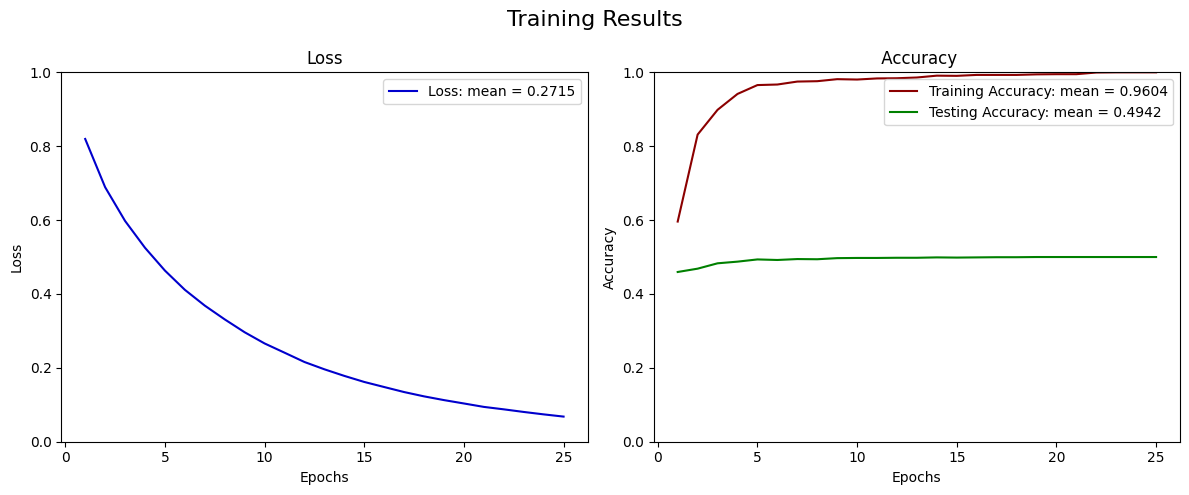

In [147]:
# Plot Loss and Accuracy
def plot_training_results(loss_values, train_acc_values, test_acc_values):
    epochs = range(1, len(loss_values) + 1)  # Create a list of epoch numbers
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)
    mean_loss = mean(loss_values)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, loss_values, color='mediumblue', label=(f"Loss: mean = {mean_loss:.4f}"))
    ax1.set_ylim(0, 1)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy: mean = {mean_train_acc:.4f}"))
    ax2.plot(epochs, test_acc_values, color='green', label=(f"Testing Accuracy: mean = {mean_test_acc:.4}"))
    ax2.set_ylim(0, 1)
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results(loss_values, train_acc_values, test_acc_values)


Compute ROC Curve and AUC

In [148]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [149]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

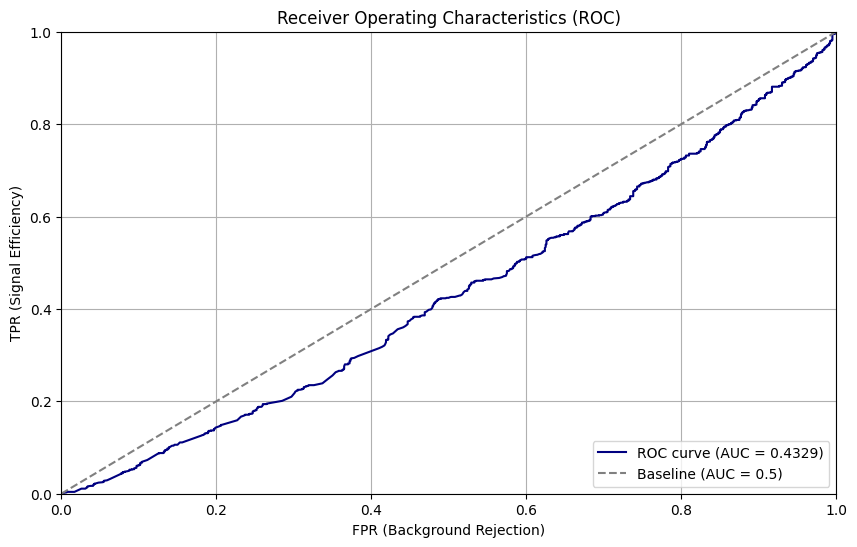

In [151]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('TPR (Signal Efficiency)')
plt.xlabel('FPR (Background Rejection)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()